In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

In [2]:
input_shape = (28, 28, 1)
num_classes = 10

In [3]:
inputs = layers.Input(input_shape, dtype=tf.float64)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# PreProcess
텐서플로 공홈에서 말한 expert한 방법
tf.data를 사용한다.

In [4]:
mnist = tf.keras.datasets.mnist

# Load Data from MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Channel 차원 추가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Data Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)

# Visualize Data
mapplotlib 불러와 데이터 시각화

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
#배치 사이즈만큼 가져오게 된다.
(32, 28, 28, 1)
image, label = next(iter(train_ds))
print(label)

tf.Tensor([1 5 7 1 2 7 7 8 8 6 7 1 0 0 2 2 3 2 3 0 6 2 3 4 3 0 0 4 6 6 3 4], shape=(32,), dtype=uint8)


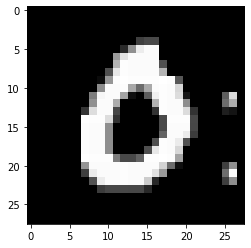

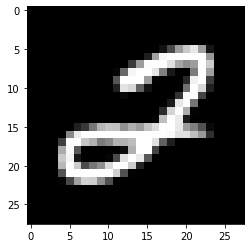

In [8]:
for image, label in train_ds.take(2):
    plt.imshow(image[0, :, :, 0], 'gray')
    plt.show()

In [11]:
#이제 training 준비( data 준비)가 되었으니 해보도록 하자
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy')
# 배치 사이즈는 이미 설정했으니 ,데이터와 에폭만 넣어주면 된다.
model.fit(train_ds , epochs=1, shuffle=True)

#이게 keras 방식이다. 

1875/1875 [==============================] - 153s 82ms/step - loss: 0.0994


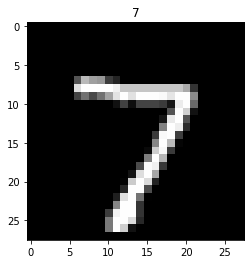

In [14]:
import matplotlib.pyplot as plt
import numpy as np
test_image = x_test[0, : , : ,0]
test_image.shape
plt.title(y_test[0])
plt.imshow(test_image,'gray')
plt.show()


In [15]:
pred = model.predict(test_image.reshape(1,28,28,1))
pred.shape

(1, 10)

In [16]:
pred

array([[3.2976419e-10, 7.5493753e-09, 3.0125676e-08, 1.9921581e-08,
        1.5918049e-08, 2.9812630e-10, 6.2306104e-14, 9.9999833e-01,
        4.2681741e-10, 1.6418816e-06]], dtype=float32)

In [17]:
np.argmax(pred)

7

In [ ]:
#아래가 tensorflow에서 추천하는 expert한 방식이다. 아래 부분이 tensorflow스러운 방식으로 학습하는 것이다.
#즉, model.fit 에 해당하는 부분이다.

In [ ]:
#optimization
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
#loss를 에폭마다 평균값을 내어 보도록 하자
#loss가 낮을 때도 ,높을 때도 있다. dataset마다 다른데,
#그 때 마다의 loss를 보이게 하면 그래프가 엄청 뛰게 된다.
#그래서 에폭마다 loss의 평균을 내어 계산하는게 좋다.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training , test
tf.function -> 기존 seesion 열었던 것처럼 바로 작동 안하고, 그래프만 만들고, 학습이 시작되면 돌아가도록 한다.

tensorflow 1.x 때는 그래프를 먼저 그린다음, session을 열어 학습이 돌아가도록 했다.
2.0에서는 session이 없어서 대신 tf.function을 사용한다.
학습이 시작해서 그래프가 작동하기 시작하면, train_step도 같이 작동하게 되어 속도가 빠르다.

In [ ]:
#기울기를 얻어 훈련을 한다.
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        #예측이 나올 것이다.
        predictions  = model(images)
        #loss를 계산한다.
        loss = loss_object(labels, predictions)
    #tape로 기울기를 가져오는 것이다. 기울기로 loss를 예측한다.\
    #trainable_variables로 하여금 loss를 통해 기울기를 얻는 것이다.
    gradients = tape.gradient(loss, model.trainable_variables)
    #그 기울기를 아담에 적용하는 것이다.
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
for epoch in range(2):
    print("start trainning")
    for images , labels in train_ds:
        train_step(images, labels)
    #한 에폭의 학습이 끝이나면, 테스트한다. 즉 한 에폭에 테스트와 테스트가 반복되게 했다.
    for test_images , test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, loss: {} , Accuracy: {}, test loss : {}, test accuracy : {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))